In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from tensorflow import keras
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/san-andreas/earthquake_data.csv'
data = pd.read_csv(url, index_col = 0)

In [3]:
data

,"How worried are you about the Big One, a massive, catastrophic earthquake?","Do you think the ""Big One"" will occur in your lifetime?",Have you ever experienced an earthquake?,"Have you or anyone in your household taken any precautions for an earthquake (packed an earthquake survival kit, prepared an evacuation plan, etc.)?",How familiar are you with the San Andreas Fault line?,How familiar are you with the Yellowstone Supervolcano?,Age,What is your gender?,How much total combined money did all members of your HOUSEHOLD earn last year?,US Region
"In general, how worried are you about earthquakes?",,,,,,,,,,
Not at all worried,Not so worried,No,"Yes, one or more minor ones",No,Somewhat familiar,Not so familiar,18 - 29,Male,Prefer not to answer,New England
Somewhat worried,Very worried,No,"Yes, one or more minor ones",No,Not at all familiar,Not at all familiar,18 - 29,Male,"$75,000 to $99,999",East North Central
Not so worried,Somewhat worried,No,"Yes, one or more minor ones",No,Very familiar,Somewhat familiar,18 - 29,Male,"$10,000 to $24,999",Pacific
Not so worried,Not so worried,No,"Yes, one or more minor ones",No,Very familiar,Not so familiar,18 - 29,Male,"$25,000 to $49,999",West South Central
Not so worried,Not so worried,Yes,"Yes, one or more minor ones",No,Somewhat familiar,Extremely familiar,18 - 29,Male,"$200,000 and up",Middle Atlantic
...,...,...,...,...,...,...,...,...,...,...
Not at all worried,Not at all worried,No,"Yes, one or more minor ones",No,Very familiar,Not so familiar,60,Male,Prefer not to answer,Pacific
Not so worried,Somewhat worried,No,"Yes, one or more major ones",Yes,Extremely familiar,Somewhat familiar,60,Female,"$50,000 to $74,999",Pacific
Not so worried,Extremely worried,No,"Yes, one or more minor ones",No,Somewhat familiar,Somewhat familiar,30 - 44,Female,Prefer not to answer,Middle Atlantic


In [4]:
data.isnull().sum()

How worried are you about the Big One, a massive, catastrophic earthquake?                                                                               0
Do you think the "Big One" will occur in your lifetime?                                                                                                  0
Have you ever experienced an earthquake?                                                                                                                 7
Have you or anyone in your household taken any precautions for an earthquake (packed an earthquake survival kit, prepared an evacuation plan, etc.)?     7
How familiar are you with the San Andreas Fault line?                                                                                                   12
How familiar are you with the Yellowstone Supervolcano?                                                                                                 12
Age                                                                   

Let's drop null rows

In [5]:
#Cleaning Data
data.dropna(inplace = True)
data.isnull().sum()

How worried are you about the Big One, a massive, catastrophic earthquake?                                                                              0
Do you think the "Big One" will occur in your lifetime?                                                                                                 0
Have you ever experienced an earthquake?                                                                                                                0
Have you or anyone in your household taken any precautions for an earthquake (packed an earthquake survival kit, prepared an evacuation plan, etc.)?    0
How familiar are you with the San Andreas Fault line?                                                                                                   0
How familiar are you with the Yellowstone Supervolcano?                                                                                                 0
Age                                                                         

Now we need to encode every column. First we need to check if there is a scale order to the answer.

In [6]:
for col in data.columns:
    print( data[col].unique())

['Not so worried' 'Very worried' 'Somewhat worried' 'Not at all worried'
 'Extremely worried']
['No' 'Yes']
['Yes, one or more minor ones' 'No' 'Yes, one or more major ones']
['No' 'Yes']
['Somewhat familiar' 'Not at all familiar' 'Very familiar'
 'Not so familiar' 'Extremely familiar']
['Not so familiar' 'Not at all familiar' 'Somewhat familiar'
 'Extremely familiar' 'Very familiar']
['18 - 29' '30 - 44' '45 - 59' '60']
['Male' 'Female']
['Prefer not to answer' '$75,000 to $99,999' '$10,000 to $24,999'
 '$25,000 to $49,999' '$200,000 and up' '$50,000 to $74,999'
 '$0 to $9,999' '$100,000 to $124,999' '$175,000 to $199,999'
 '$125,000 to $149,999' '$150,000 to $174,999']
['New England' 'East North Central' 'Pacific' 'West South Central'
 'Middle Atlantic' 'South Atlantic' 'West North Central'
 'East South Central' 'Mountain']


In [7]:
data_encoded = pd.DataFrame(data.values)
data_encoded.columns = ['big one', 'big one occurence','experienced hq', 'precautions', 'sa familiarity', 'ys familiarity', 'age', 'gender', 'income', 'region']
data_encoder = OrdinalEncoder()
data_encoded.iloc[:,[1,2,3,6,7,8,9]] = data_encoder.fit_transform(data.iloc[:,[1,2,3,6,7,8,9]])

#Ordered index for some columnns to maintain a logical scale
map1 = {'Not at all worried':0., 'Not so worried':1., 'Somewhat worried':2., 'Very worried':3., 'Extremely worried':4.}
map2 = {'Not at all familiar':0., 'Not so familiar':1., 'Somewhat familiar':2., 'Very familiar':3., 'Extremely familiar':4.}

data_encoded.iloc[:,0] = np.array(data.iloc[:,0].map(map1))
data_encoded.iloc[:,4] = np.array(data.iloc[:,4].map(map2))
data_encoded.iloc[:,5] = np.array(data.iloc[:,5].map(map2))

data_encoded['worry scale'] = data.index.map(map1)

data_encoded = data_encoded.astype(float)
data_encoded.info()
data_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   big one            978 non-null    float64
 1   big one occurence  978 non-null    float64
 2   experienced hq     978 non-null    float64
 3   precautions        978 non-null    float64
 4   sa familiarity     978 non-null    float64
 5   ys familiarity     978 non-null    float64
 6   age                978 non-null    float64
 7   gender             978 non-null    float64
 8   income             978 non-null    float64
 9   region             978 non-null    float64
 10  worry scale        978 non-null    float64
dtypes: float64(11)
memory usage: 84.2 KB


,big one,big one occurence,experienced hq,precautions,sa familiarity,ys familiarity,age,gender,income,region,worry scale
0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,10.0,4.0,0.0
1,3.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,2.0
2,2.0,0.0,2.0,0.0,3.0,2.0,0.0,1.0,1.0,5.0,1.0
3,1.0,0.0,2.0,0.0,3.0,1.0,0.0,1.0,7.0,8.0,1.0
4,1.0,1.0,2.0,0.0,2.0,4.0,0.0,1.0,6.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
973,0.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,10.0,4.0,0.0
974,0.0,0.0,2.0,0.0,3.0,1.0,3.0,1.0,10.0,5.0,0.0
975,2.0,0.0,1.0,1.0,4.0,2.0,3.0,0.0,8.0,5.0,1.0
976,4.0,0.0,2.0,0.0,2.0,2.0,1.0,0.0,10.0,2.0,1.0


<AxesSubplot:>

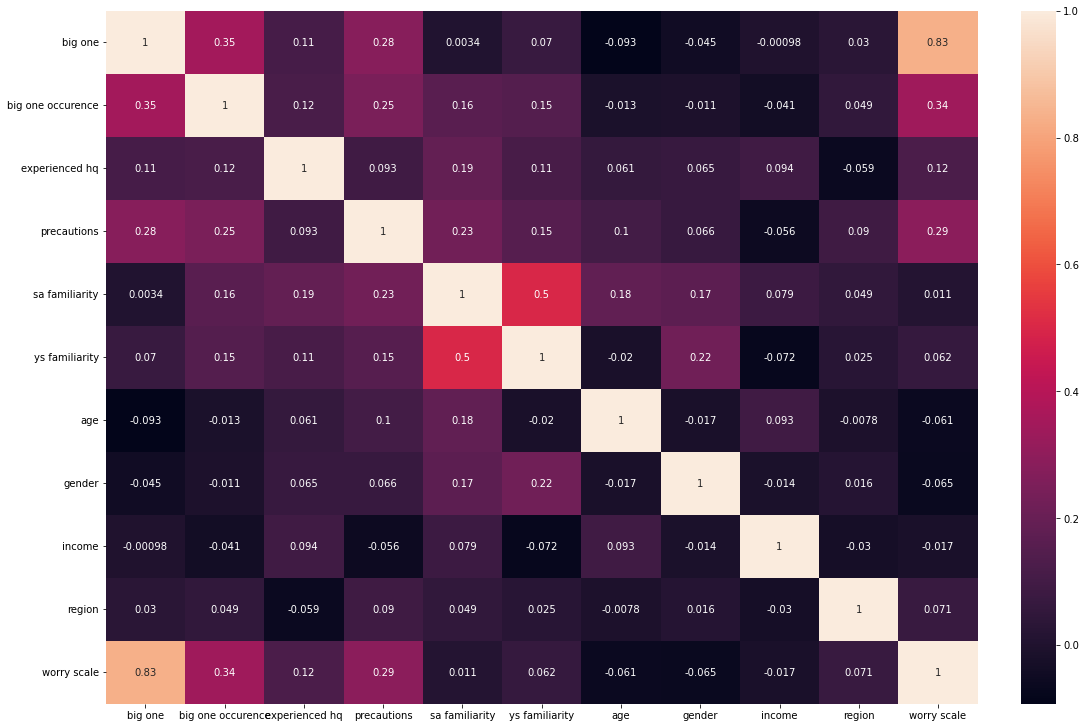

In [8]:
corr = data_encoded.corr()
sns.heatmap(corr, annot = True)

The only high correlation is between yellowstone familiarity and san andreas familiarity, for now we will leave it this way.
<br>
Let's split data and train the algorithms, considerations will be taken at the end of training and predictions of every model.
<br>
Let's train a beseline models

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(data_encoded.iloc[:,:-1], data_encoded.iloc[:,-1])
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
svc = SVC()
lr = LogisticRegression(max_iter=1000000)

rf.fit(xtrain, ytrain)
gb.fit(xtrain, ytrain)
svc.fit(xtrain, ytrain)
lr.fit(xtrain, ytrain)

print(f'Random forest: train score {rf.score(xtrain,ytrain)}, test score {rf.score(xtest, ytest)}')
print(f'Gradient boosting: train score {gb.score(xtrain,ytrain)}, test score {gb.score(xtest, ytest)}')
print(f'SVC: train score {svc.score(xtrain,ytrain)}, test score {svc.score(xtest, ytest)}')
print(f'Logistic regression: train score {lr.score(xtrain,ytrain)}, test score {lr.score(xtest, ytest)}')

Random forest: train score 0.9986357435197817, test score 0.726530612244898
Gradient boosting: train score 0.8622100954979536, test score 0.7224489795918367
SVC: train score 0.694406548431105, test score 0.7346938775510204
Logistic regression: train score 0.7121418826739427, test score 0.7306122448979592


Tree-based models are overfitting, svc and logistic regression perform better even without scaling.
Let's tune the hyperparameters and see if there is any change

0.8431105047748977 0.6861615879228403 0.7428571428571429
{'max_depth': 7, 'n_estimators': 110}


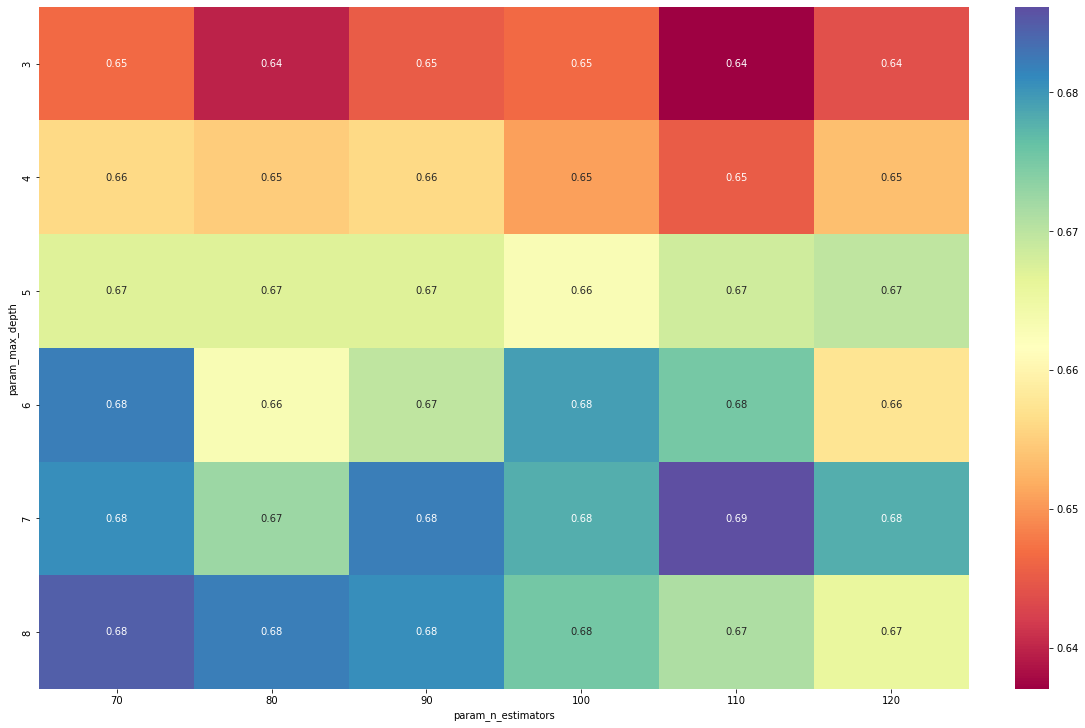

In [10]:
#Random forest Classifier
parameters = {'max_depth':[d for d in range(3,9)], 'n_estimators':[i*10 for i in range(7,13)]}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, parameters, n_jobs=-1) 
rf_grid.fit(xtrain, ytrain)
best_rf = rf_grid.best_estimator_

#Plot grid
hmRF = pd.pivot_table(pd.DataFrame(rf_grid.cv_results_),
									values='mean_test_score',
									index='param_max_depth',
									columns='param_n_estimators')

sns.heatmap(hmRF, cmap = 'Spectral', annot = True)                                        
print(rf_grid.score(xtrain, ytrain), rf_grid.best_score_, rf_grid.score(xtest, ytest))
print(rf_grid.best_params_)

,precision,recall,f1-score,support
0.0,0.91,0.88,0.90,94.00
1.0,0.66,0.75,0.70,76.00
2.0,0.65,0.65,0.65,54.00
3.0,0.00,0.00,0.00,11.00
4.0,0.64,0.70,0.67,10.00
accuracy,0.74,0.74,0.74,0.74
macro avg,0.57,0.60,0.58,245.00
weighted avg,0.72,0.74,0.73,245.00


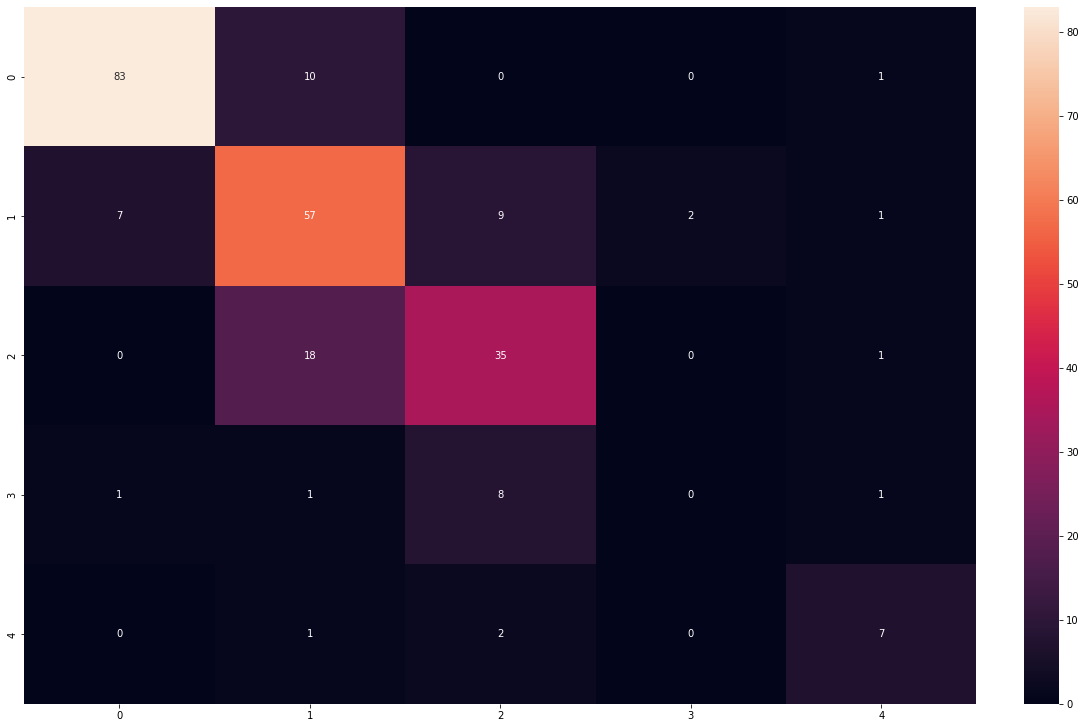

In [11]:
cm_rf = confusion_matrix(ytest, rf_grid.predict(xtest))
sns.heatmap(cm_rf, annot=True)
rf_cr = pd.DataFrame(classification_report(ytest, rf_grid.predict(xtest), output_dict=True)).transpose().round(2)
rf_cr

0.7517053206002728 0.7216009691547851 0.763265306122449
{'learning_rate': 0.05, 'max_depth': 2}


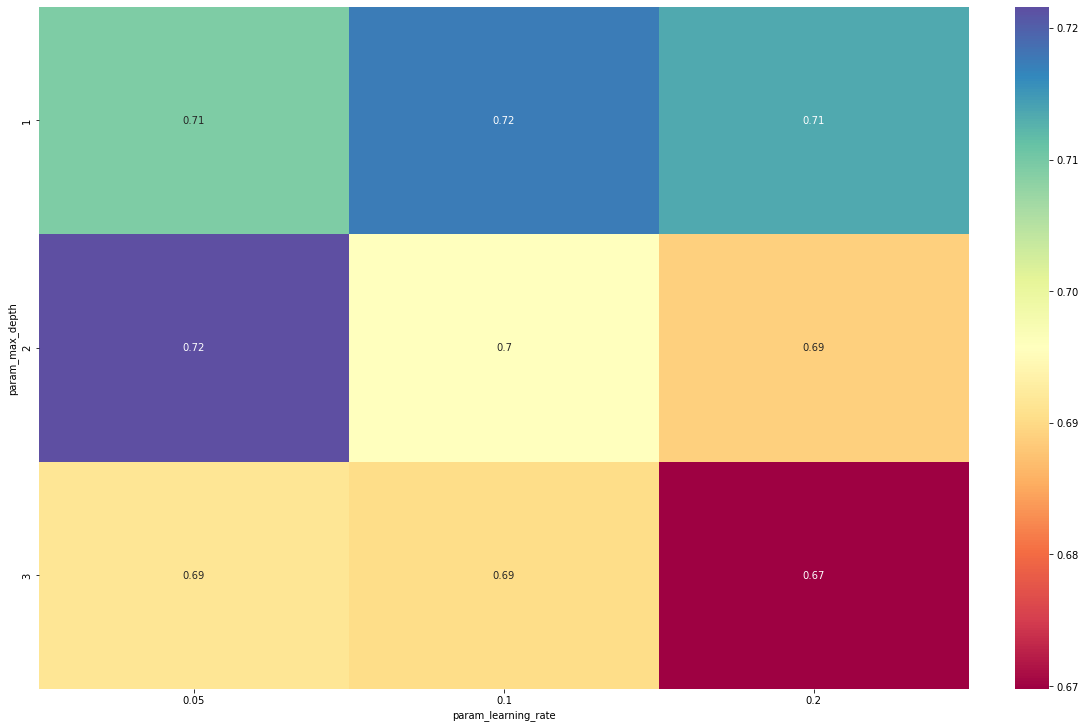

In [12]:
#Gradient Boosting Classifier
params = {'learning_rate':[0.05, 0.1, 0.2], 'max_depth':[1,2,3]}

gb = GradientBoostingClassifier(max_features = 'sqrt')
gb_grid = GridSearchCV(gb, params, n_jobs=-1)
gb_grid.fit(xtrain, ytrain)
best_gb = gb_grid.best_estimator_

#Plot grid
hmGB = pd.pivot_table(pd.DataFrame(gb_grid.cv_results_),
									values='mean_test_score',
									index='param_max_depth',
									columns='param_learning_rate')
sns.heatmap(hmGB, cmap = 'Spectral', annot = True)

print(gb_grid.score(xtrain, ytrain), gb_grid.best_score_, gb_grid.score(xtest, ytest))
print(gb_grid.best_params_)

,precision,recall,f1-score,support
0.0,0.91,0.87,0.89,94.00
1.0,0.72,0.67,0.69,76.00
2.0,0.68,0.78,0.72,54.00
3.0,0.43,0.27,0.33,11.00
4.0,0.60,0.90,0.72,10.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.67,0.70,0.67,245.00
weighted avg,0.77,0.76,0.76,245.00


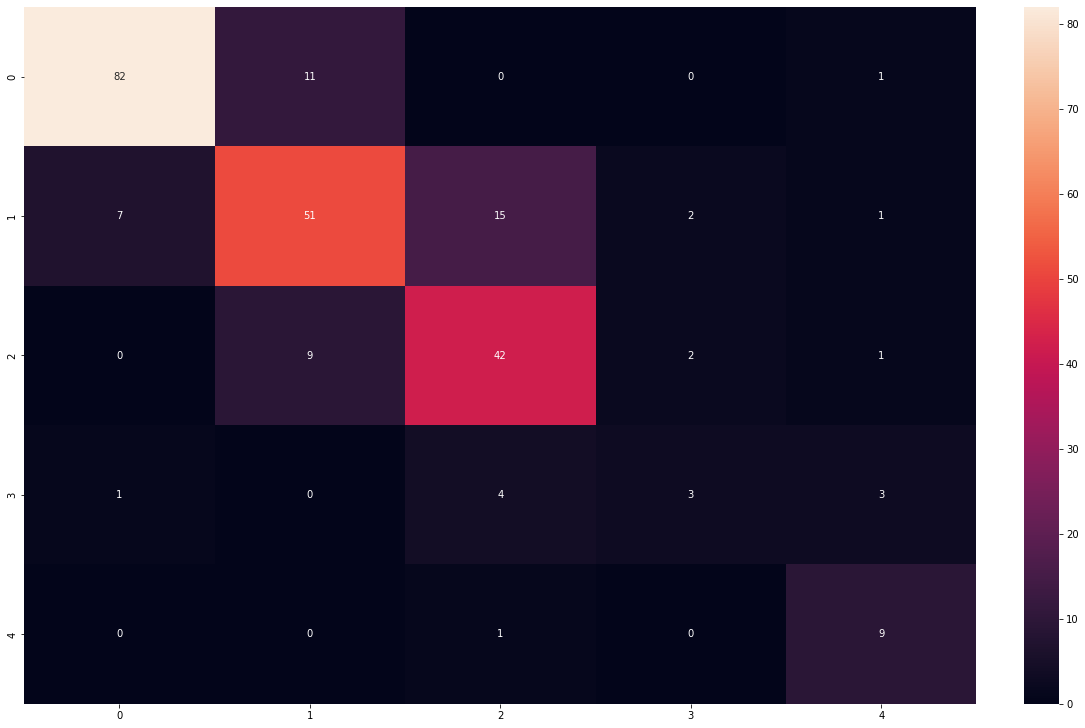

In [13]:
cm_gb = confusion_matrix(ytest, gb_grid.predict(xtest))
sns.heatmap(cm_gb, annot=True)
gb_cr = pd.DataFrame(classification_report(ytest, gb_grid.predict(xtest), output_dict=True)).transpose().round(2)
gb_cr

svm best parameters {'C': 0.5, 'kernel': 'linear'}
svm: best train score 0.719| mean validation score 0.708| test score 0.755


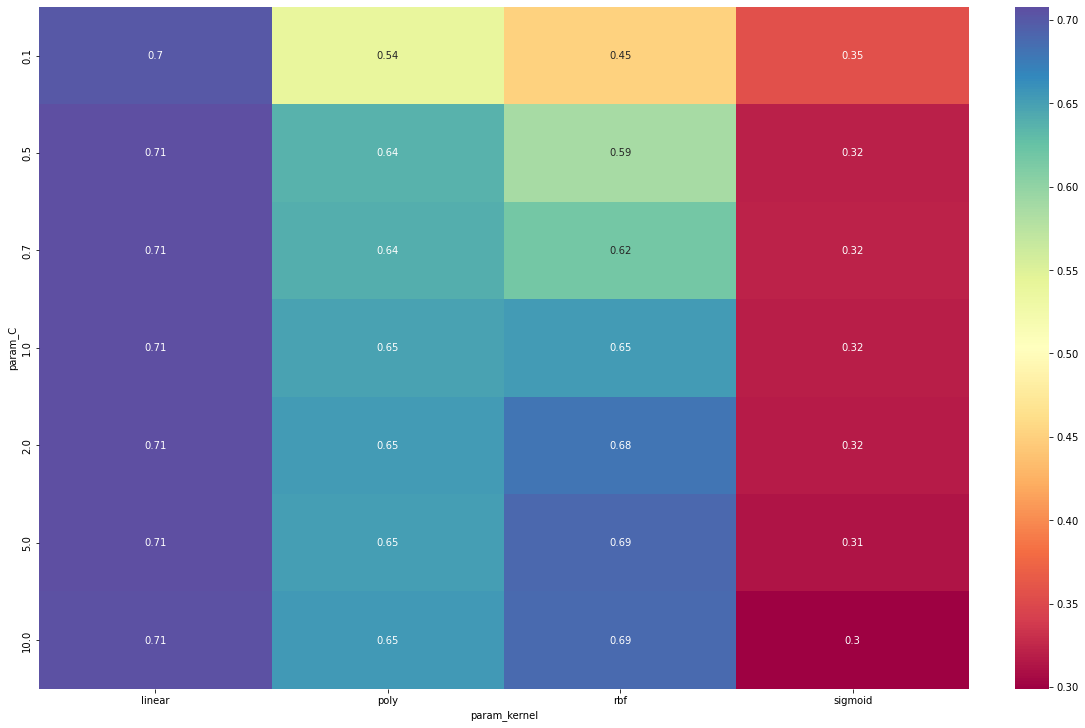

In [14]:
#SVC
svm_params = {'C': [0.1, 0.5, 0.7,  1, 2, 5, 10],
              'kernel':['linear', 'poly', 'rbf', 'sigmoid'] }
               
svm_grid = GridSearchCV(SVC(), svm_params, n_jobs=-1)
svm_grid.fit(xtrain, ytrain)
best_svc = svm_grid.best_estimator_
    
#Plot grid
hmsvm = pd.pivot_table(pd.DataFrame(svm_grid.cv_results_),
									values='mean_test_score',
									index='param_C',
									columns='param_kernel')
sns.heatmap(hmsvm, cmap = 'Spectral', annot = True)

print(f'svm best parameters {svm_grid.best_params_}')
print(f'svm: best train score {np.round(svm_grid.score(xtrain, ytrain), 3)}| mean validation score {np.round(svm_grid.best_score_, 3)}| test score {np.round(svm_grid.score(xtest, ytest), 3)}')

,precision,recall,f1-score,support
0.0,0.91,0.87,0.89,94.00
1.0,0.75,0.64,0.70,76.00
2.0,0.62,0.81,0.70,54.00
3.0,0.50,0.18,0.27,11.00
4.0,0.53,0.80,0.64,10.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.66,0.66,0.64,245.00
weighted avg,0.76,0.76,0.75,245.00


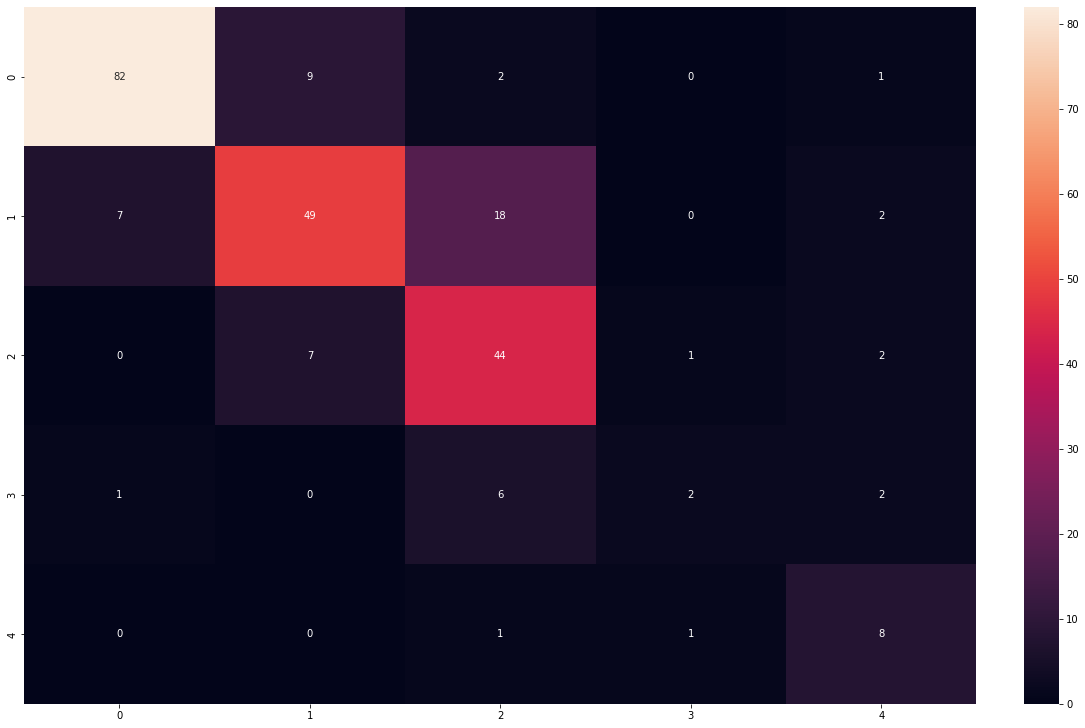

In [15]:
cm_svm = confusion_matrix(ytest, svm_grid.predict(xtest))
sns.heatmap(cm_svm, annot=True)
svm_cr = pd.DataFrame(classification_report(ytest, svm_grid.predict(xtest), output_dict=True)).transpose().round(2)
svm_cr

In [16]:
#Logistic regression
lr_params = {'C': [0.1, 0.5, 0.7,  1, 2, 5, 10]}
               
lr_grid = GridSearchCV(LogisticRegression(max_iter = 100000), lr_params, n_jobs=-1)
lr_grid.fit(xtrain, ytrain)
best_log = lr_grid.best_estimator_
    
print(f'lr best parameters {lr_grid.best_params_}')
print(f'lr: best train score {np.round(lr_grid.score(xtrain, ytrain), 3)}| mean validation score {np.round(lr_grid.best_score_, 3)}| test score {np.round(lr_grid.score(xtest, ytest), 3)}')

lr best parameters {'C': 5}
lr: best train score 0.714| mean validation score 0.683| test score 0.727


,precision,recall,f1-score,support
0.0,0.91,0.87,0.89,94.00
1.0,0.66,0.72,0.69,76.00
2.0,0.65,0.65,0.65,54.00
3.0,0.20,0.09,0.13,11.00
4.0,0.38,0.50,0.43,10.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.56,0.57,0.56,245.00
weighted avg,0.72,0.73,0.72,245.00


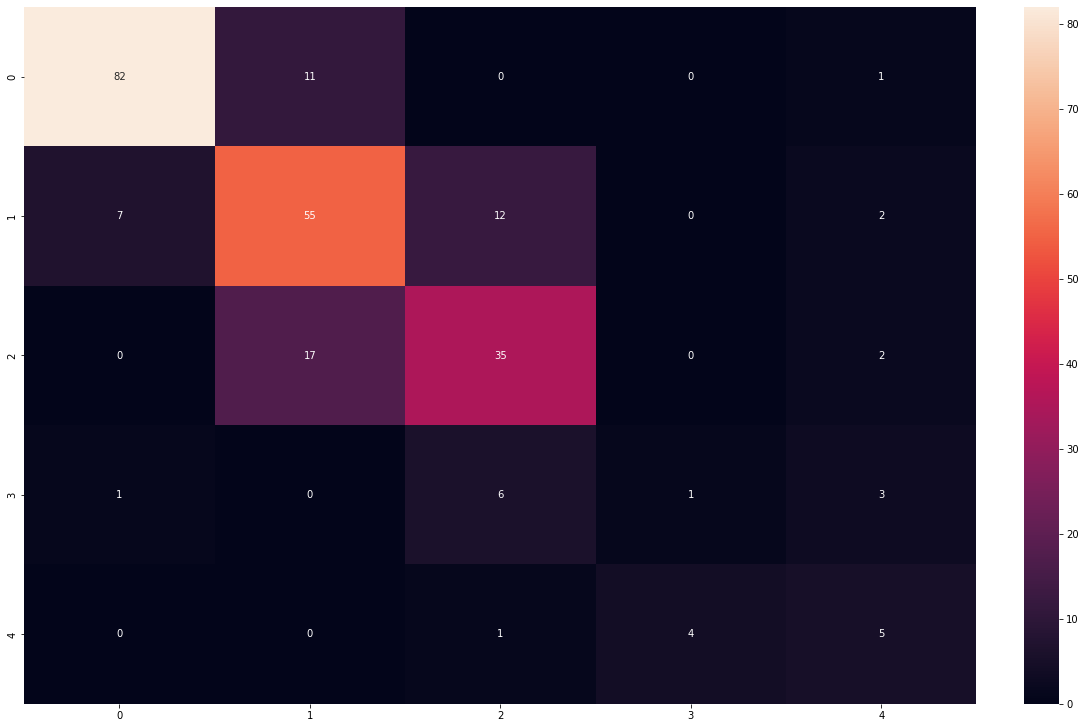

In [17]:
cm_lr = confusion_matrix(ytest, lr_grid.predict(xtest))
sns.heatmap(cm_lr, annot=True)
lr_cr = pd.DataFrame(classification_report(ytest, lr_grid.predict(xtest), output_dict=True)).transpose().round(2)
lr_cr

Even with hyperparameters tuning, the accuracy of the models didn't increase, but we reduced overfitting.
<br>
As we can see from the previous algorithms we can estimante with around 70% people's worry degree about an earthquake. 
<br>
The algorithms used performs in a similar way, but gradient boosting overfit less, so this would be the best pick.
<br> 
Observing the confusion matrices one can say that even when algorithms missmatch, the prevsion is near the correct answer, in fact we can see the form of a tridiagonal matrix.

Let's see if stacking algorithms produces a better result. First try voting classifier

In [18]:
decisions_train = pd.DataFrame({'rf':rf_grid.predict(xtrain),
                          'gb':gb_grid.predict(xtrain),
                          'svm':svm_grid.predict(xtrain),
                          'lr':lr_grid.predict(xtrain)})

decisions_test = pd.DataFrame({'rf':rf_grid.predict(xtest),
                          'gb':gb_grid.predict(xtest),
                          'svm':svm_grid.predict(xtest),
                          'lr':lr_grid.predict(xtest)})

In [19]:
vc = VotingClassifier([('rf',best_rf),('gb',best_gb),('lr',best_log)], voting='soft')

vc.fit(xtrain, ytrain)

print(vc.score(xtrain, ytrain), vc.score(xtest, ytest)) 

0.7598908594815825 0.7591836734693878


,precision,recall,f1-score,support
0.0,0.91,0.87,0.89,94.00
1.0,0.69,0.71,0.70,76.00
2.0,0.66,0.74,0.70,54.00
3.0,1.00,0.09,0.17,11.00
4.0,0.60,0.90,0.72,10.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.77,0.66,0.63,245.00
weighted avg,0.78,0.76,0.75,245.00


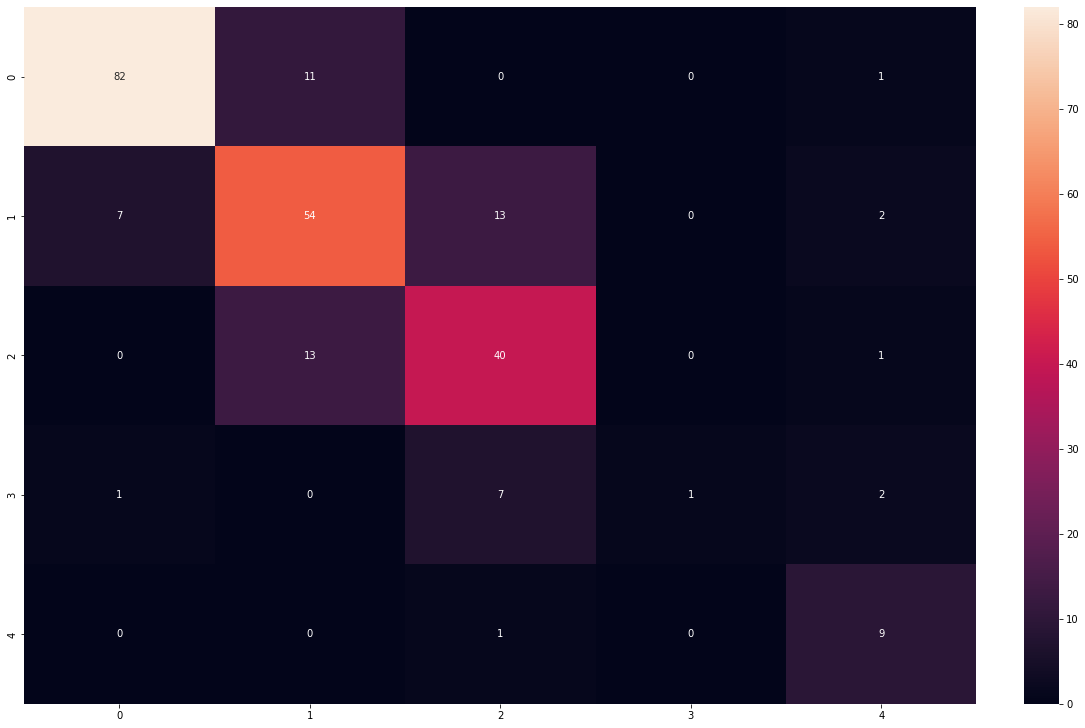

In [20]:
cm_vc = confusion_matrix(ytest, vc.predict(xtest))
sns.heatmap(cm_vc, annot=True)
vc_cr = pd.DataFrame(classification_report(ytest, vc.predict(xtest), output_dict=True)).transpose().round(2)
vc_cr

Let's try with a neural network

In [21]:
#Neural Network
RegularizedDense = partial(keras.layers.Dense,
                           activation="selu",
                           kernel_initializer="lecun_normal",
                           #kernel_regularizer=keras.regularizers.l2(0.015)
                          )

neural = keras.models.Sequential([
        keras.layers.InputLayer(input_shape = decisions_train.shape[1]),
        RegularizedDense(20),
        RegularizedDense(10),
        keras.layers.Dense(len(np.unique(ytrain)), activation = 'softmax')])

neural.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])
history = neural.fit(decisions_train, ytrain,
                    epochs = 130,
                    verbose = 0)
    
neural.evaluate(decisions_test, ytest)[1]

8/8 [==============================] - 0s 2ms/step - loss: 0.8872 - accuracy: 0.7510


0.7510204315185547

8/8 [==============================] - 0s 1ms/step


,precision,recall,f1-score,support
0.0,0.91,0.88,0.90,94.00
1.0,0.66,0.75,0.70,76.00
2.0,0.69,0.65,0.67,54.00
3.0,0.50,0.18,0.27,11.00
4.0,0.58,0.70,0.64,10.00
accuracy,0.75,0.75,0.75,0.75
macro avg,0.67,0.63,0.63,245.00
weighted avg,0.75,0.75,0.75,245.00


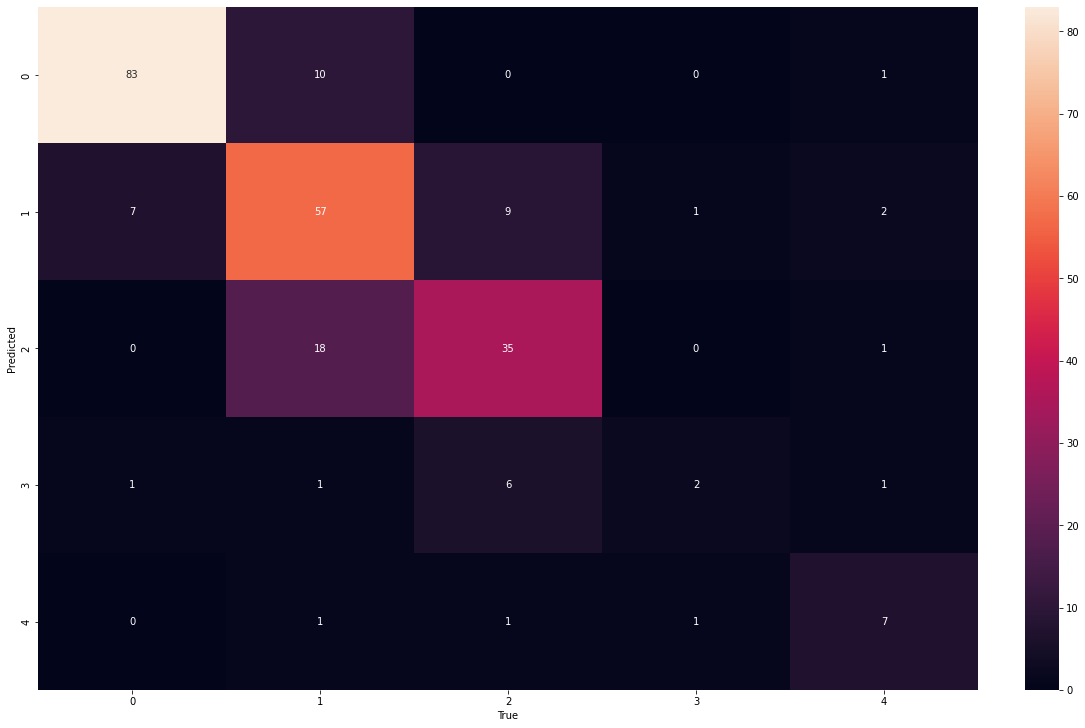

In [22]:
mlp_predictions = np.argmax(neural.predict(decisions_test), axis = 1)
mlp_cm = confusion_matrix(ytest, mlp_predictions)
mlp_cr = pd.DataFrame(classification_report(ytest, mlp_predictions, output_dict=True)).transpose().round(2)
sns.heatmap(mlp_cm, annot=True)
plt.xlabel('True')
plt.ylabel('Predicted')
mlp_cr

The general accuracy si comparable to other models, but observing the f1 score in the classification report we can see that the stacking predictions are more balanced.
<br>
Just to have more clarity about it, let's print every report here

In [23]:
#Thank you god from stack overflow
from IPython.display import display_html

rf = rf_cr.style.set_table_attributes("style='display:inline'").set_caption('Random Forest')
gb = gb_cr.style.set_table_attributes("style='display:inline'").set_caption('Gradient boosting')
svm = svm_cr.style.set_table_attributes("style='display:inline'").set_caption('SVM')
lr = lr_cr.style.set_table_attributes("style='display:inline'").set_caption('Logistic Regression')
stack_vc = vc_cr.style.set_table_attributes("style='display:inline'").set_caption('Voting Classifier')
stack_mlp = mlp_cr.style.set_table_attributes("style='display:inline'").set_caption('Stack MLP')
 
display_html(rf._repr_html_()+gb._repr_html_(), raw=True)
display_html(svm._repr_html_()+lr._repr_html_(), raw=True)
display_html(stack_vc._repr_html_()+stack_mlp._repr_html_(), raw=True)  

,precision,recall,f1-score,support
0.0,0.910000,0.880000,0.900000,94.000000
1.0,0.660000,0.750000,0.700000,76.000000
2.0,0.650000,0.650000,0.650000,54.000000
3.0,0.000000,0.000000,0.000000,11.000000
4.0,0.640000,0.700000,0.670000,10.000000
accuracy,0.740000,0.740000,0.740000,0.740000
macro avg,0.570000,0.600000,0.580000,245.000000
weighted avg,0.720000,0.740000,0.730000,245.000000
,precision,recall,f1-score,support
0.0,0.910000,0.870000,0.890000,94.000000


,precision,recall,f1-score,support
0.0,0.910000,0.870000,0.890000,94.000000
1.0,0.750000,0.640000,0.700000,76.000000
2.0,0.620000,0.810000,0.700000,54.000000
3.0,0.500000,0.180000,0.270000,11.000000
4.0,0.530000,0.800000,0.640000,10.000000
accuracy,0.760000,0.760000,0.760000,0.760000
macro avg,0.660000,0.660000,0.640000,245.000000
weighted avg,0.760000,0.760000,0.750000,245.000000
,precision,recall,f1-score,support
0.0,0.910000,0.870000,0.890000,94.000000


,precision,recall,f1-score,support
0.0,0.910000,0.870000,0.890000,94.000000
1.0,0.690000,0.710000,0.700000,76.000000
2.0,0.660000,0.740000,0.700000,54.000000
3.0,1.000000,0.090000,0.170000,11.000000
4.0,0.600000,0.900000,0.720000,10.000000
accuracy,0.760000,0.760000,0.760000,0.760000
macro avg,0.770000,0.660000,0.630000,245.000000
weighted avg,0.780000,0.760000,0.750000,245.000000
,precision,recall,f1-score,support
0.0,0.910000,0.880000,0.900000,94.000000


Conclusions: Looking at the f1 weighted score the best overall model on this dataset is Gradient Boosting by a little margin on svm